In [18]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from time import time
import datetime
import numpy as np
from pyproj import Transformer
from filtering import dist_measure
from haversine import haversine, Unit
from pyproj import Proj
import glob, os

In [2]:
trajs = gp.read_file('./data/trajectories/trajs.shp')

In [51]:
from pyproj import Proj, transform

inProj = Proj('epsg:4326')
outProj = Proj('epsg:2100')
x1,y1 = 87.649627, 41.879176
x2,y2 = transform(inProj,outProj,x1,y1)
print(x2,y2)

580399.6620798592 9748047.196104983


<ipython-input-51-cdc912b3cbf3>:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2,y2 = transform(inProj,outProj,x1,y1)


In [42]:
RDX1 = -11705274.6374 
RDY1 = 4826473.6922
# point1 = (51.332306, 35.746346)
# point2 = (51.33229, 35.746475)
# RDX2 = 51.33229
# RDY2 = 35.746475
p1 = 'epsg:3857'
p2 = 'WGS84'
t_crs = Transformer.from_crs(crs_from=p1, crs_to=p2)

t_point1 = t_crs.transform(xx=RDX1, yy=RDY1)
# t_point2 = t_crs.transform(xx=RDX2, yy=RDY2)
# print(t_point1, t_point2)
# print(np.sqrt((t_point2[0]-t_point1[0])**2 + (t_point2[1]-t_point1[1])**2))
# print(haversine(point1[::-1], point2[::-1], unit=Unit.METERS))
t_point1

(39.72785727727917, -105.15027111593008)

In [7]:
RDX1 = 51.332306
RDY1 = 35.746346
point1 = (51.332306, 35.746346)
point2 = (51.33229, 35.746475)
RDX2 = 51.33229
RDY2 = 35.746475
p1 = 'epsg:4326'
p2 = 'epsg:2042'
t_crs = Transformer.from_crs(crs_from=p1, crs_to=p2)

t_point1 = t_crs.transform(xx=RDX1, yy=RDY1)
t_point2 = t_crs.transform(xx=RDX2, yy=RDY2)
print(t_point1, t_point2)
print(np.sqrt((t_point2[0]-t_point1[0])**2 + (t_point2[1]-t_point1[1])**2))
print(haversine(point1[::-1], point2[::-1], unit=Unit.METERS))

(3515845.9153668415, 6696638.370253177) (3515855.041627125, 6696642.931454808)
10.202606876670927
14.41665986811726


In [20]:
t_point1

(-511849.4507443217, 5826016.940788595)

In [10]:
t_point2

(-559788.5743083667, 5798097.762545532)

In [23]:
np.sqrt((t_point2[0]-t_point1[0])**2 + (t_point2[1]-t_point1[1])**2)

9.288175952788501

In [30]:
haversine(point1[::-1], point2[::-1], unit=Unit.METERS)

14.41665986811726

In [2]:
np.sqrt((530044.124-530045.619)**2+(3955880.317-3955866.723)**2)
# 530044.124
# 3955880.317
# 530045.619
# 3955866.723

13.675959234673076

In [25]:
wgs2utm = Proj(proj='utm', zone=39, ellps='WGS84', preserve_units=False)
x1, y1 = wgs2utm(51.332306, 35.746346)
x2, y2 = wgs2utm(51.33229, 35.746475)
print(x, y)

530045.6192757702 3955866.013966034


In [15]:
np.sqrt((x2-x1)**2+(y2-y1)**2)

14.380490757054558

In [74]:
wgs2utm = Proj(proj='utm', zone=39, ellps='WGS84', preserve_units=False)
dirpath = './data/gps-csv/sample-area/'
out_dir = './data/gps-csv/sample-new/'
os.makedirs(out_dir, exist_ok=True)
all_files = os.listdir(dirpath)
for file_name in all_files:
    temp_df = pd.read_csv(os.path.join(dirpath, file_name), sep=',')
    temp_df = temp_df[temp_df.altitude.notna()]
    temp_df['coords'] = temp_df[['longitude', 'latitude']].apply(
        lambda x: wgs2utm(x.longitude, x.latitude), axis=1
    )
    temp_df[['longitude', 'latitude']] = pd.DataFrame(
        temp_df['coords'].tolist(), index=temp_df.index
    )
    temp_df = temp_df[['route_id', 'longitude', 'latitude', 'altitude', 'timestamp']]
    temp_df.to_csv(os.path.join(out_dir, file_name), sep=',', header=True, index=False)

In [68]:
temp_file

,route_id,longitude,latitude,altitude,timestamp,bearing,speed,coords
0,91412,528712.517380,3.956368e+06,1374.3885,2020-07-19 07:06:26.438,2.076690,32.115344,"(528712.5173796131, 3956367.576299222)"
1,91412,528712.922020,3.956382e+06,1375.5325,2020-07-19 07:06:28.612,2.076690,24.616338,"(528712.9220198275, 3956382.217956445)"
2,91412,528713.589987,3.956399e+06,1375.9788,2020-07-19 07:06:34.094,1.384793,19.383716,"(528713.5899870201, 3956399.300524725)"
3,91412,528713.572027,3.956405e+06,1375.1040,2020-07-19 07:06:35.179,1.384793,19.944256,"(528713.5720269933, 3956404.8460526946)"
4,91412,528713.801590,3.956418e+06,1374.5055,2020-07-19 07:06:37.345,1.384793,24.219283,"(528713.8015900378, 3956417.7125561885)"
...,...,...,...,...,...,...,...,...
50960,109509,526676.482793,3.956658e+06,1401.0000,2020-07-19 14:02:19.670,271.089630,53.860799,"(526676.4827934992, 3956657.5719496235)"
50961,109509,526665.814702,3.956658e+06,1401.0000,2020-07-19 14:02:20.663,271.082150,53.358089,"(526665.8147016144, 3956657.539854254)"
50962,109509,526645.743557,3.956658e+06,1401.0000,2020-07-19 14:02:22.690,271.082150,49.412254,"(526645.7435570385, 3956657.7013272936)"
50963,109509,526637.606877,3.956658e+06,1401.0000,2020-07-19 14:02:23.157,271.082150,47.867879,"(526637.6068770674, 3956657.676874828)"


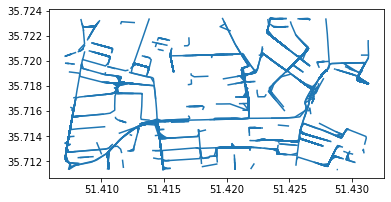

In [105]:
METERS_PER_DEGREE_LATITUDE = 111120
t = 5  # seconds
unmatched_thresh = 50*t/METERS_PER_DEGREE_LATITUDE
trajs_matches['unmatched'] = trajs_matches.spdist.apply(
    lambda x: max(
        [float(y) for y in x.split(',')]
    ) if pd.notna(x) else 1
)
trajs_matches['unmatched'] = ((trajs_matches.unmatched>unmatched_thresh) &\
                              (trajs_matches.unmatched<1)) | (trajs_matches.cpath.isna())
unmatched_df = trajs.loc[trajs_matches[trajs_matches.unmatched==True].index]
unmatched_df.plot()
plt.savefig('sample.png', dpi=150)

In [27]:
import glob
import os
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np

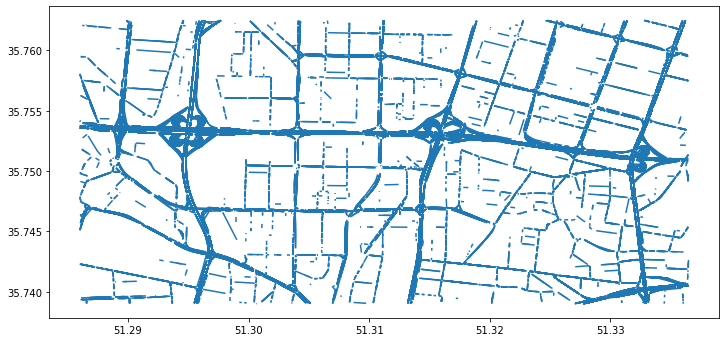

In [32]:
all_files = sorted(glob.glob(os.path.join('./data/gps-csv/', "*.csv")))
each_file_df = (pd.read_csv(f) for f in all_files)
all_trajs = pd.concat(each_file_df, ignore_index=True)
trajs = gp.read_file('./data/trajectories/trajs.shp')
fig, ax = plt.subplots(figsize=(12, 8))
trajs.plot(ax=ax)
fig.savefig('sample.png', dpi=300)

In [59]:
trajs

,id,altitude,bearing,speed,geometry
0,0,"1427.7,1437.7","31.147167,47.054375","34.315542,44.9749044","LINESTRING (51.33224 35.74940, 51.33314 35.75011)"
1,1,"1418.2714,1417.5846","278.7724,278.7724","71.26378559999999,73.3847868","LINESTRING (51.32763 35.75162, 51.32745 35.75164)"
2,2,"1463.4,1461.3,1456.0,1451.0,1444.5","276.1426,279.17444,278.7724,278.7724,279.44437","65.09779920000001,66.875724,66.59791919999999,...","LINESTRING (51.33014 35.75131, 51.32916 35.751..."
3,3,"1428.8868,1425.914,1421.0485,1419.3473,1419.3473","276.1426,279.17444,278.7724,279.44437,279.44437","63.88498800000001,64.8675,71.19964080000003,71...","LINESTRING (51.32987 35.75133, 51.32866 35.751..."
4,4,"1435.8,1431.4,1431.4,1431.0,1428.6","278.7724,279.81003,279.81003,279.44437,281.13855","65.08266479999999,64.5413616,64.5413616,62.748...","LINESTRING (51.32794 35.75158, 51.32653 35.751..."
...,...,...,...,...,...
25917,25917,"1363.0,1363.0","354.6052,354.6052","56.7074664,56.7074664","LINESTRING (51.33240 35.74549, 51.33239 35.74557)"
25918,25918,"1381.0,1381.0,1381.0,1381.0","355.67957,355.67957,354.6052,354.6052","42.01460280000001,44.52642720000001,44.5264272...","LINESTRING (51.33241 35.74535, 51.33241 35.745..."
25919,25919,"1382.5525,1383.1249,1383.1249,1383.892","355.67957,354.6052,354.6052,354.6052","45.7222968,44.050978799999996,44.0509787999999...","LINESTRING (51.33241 35.74538, 51.33240 35.745..."
25920,25920,"1408.668,1407.7395,1406.9008","273.46475,273.46475,273.46475","67.70932920000001,67.06622519999999,67.2207264","LINESTRING (51.32975 35.75161, 51.32952 35.751..."


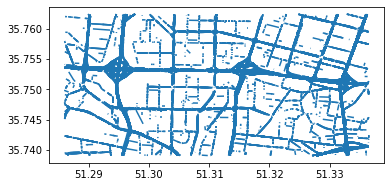

In [61]:
all_files = sorted(glob.glob(os.path.join('./data/gps-csv-first/51513535', "*.csv")))
each_file_df = (pd.read_csv(f) for f in all_files)
all_trajs = pd.concat(each_file_df, ignore_index=True)
trajs = gp.read_file('./data/trajectories-first/trajs.shp')
trajs.plot()
plt.savefig('sample-first.png', dpi=150)

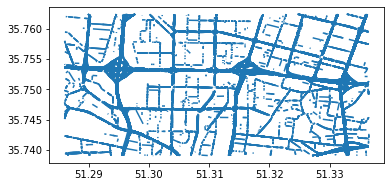

In [63]:
all_files = sorted(glob.glob(os.path.join('./data/gps-csv-second/', "*.csv")))
each_file_df = (pd.read_csv(f) for f in all_files)
all_trajs = pd.concat(each_file_df, ignore_index=True)
trajs = gp.read_file('./data/trajectories-second/trajs.shp')
trajs.plot()
plt.savefig('sample-second.png', dpi=150)

In [64]:
trajs

,id,altitude,bearing,speed,geometry
0,4,"1429.0,1429.0","88.3594,88.3594","54.97164360000001,51.703289999999996","LINESTRING (51.33597 35.75085, 51.33618 35.75086)"
1,9,"1418.2714,1417.5846","278.7724,278.7724","71.2637856,73.3847868","LINESTRING (51.32763 35.75162, 51.32745 35.75164)"
2,10,"1416.8999,1415.6456,1415.0852","278.7724,279.44437,281.13855","73.7545788,70.5556764,67.3636932","LINESTRING (51.32712 35.75169, 51.32572 35.751..."
3,12,"1417.0,1416.0,1416.0,1415.0","281.04013,281.13855,281.13855,281.13855","2.0929464e-12,20.2225428,18.90189504,15.9745716","LINESTRING (51.32505 35.75197, 51.32415 35.752..."
4,17,"1463.4,1461.3,1456.0,1451.0,1444.5","276.1426,279.17444,278.7724,278.7724,279.44437","65.0977992,66.875724,66.59791919999999,64.5977...","LINESTRING (51.33014 35.75131, 51.32916 35.751..."
...,...,...,...,...,...
32617,42813,"1381.0,1381.0,1381.0,1381.0","355.67957,355.67957,354.6052,354.6052","42.014602800000006,44.5264272,44.5264272,46.89...","LINESTRING (51.33241 35.74535, 51.33241 35.745..."
32618,42814,"1382.5525,1383.1249,1383.1249,1383.892","355.67957,354.6052,354.6052,354.6052","45.7222968,44.0509788,44.0509788,43.8221052","LINESTRING (51.33241 35.74538, 51.33240 35.745..."
32619,42815,"1408.668,1407.7395,1406.9008","273.46475,273.46475,273.46475","67.70932920000001,67.0662252,67.2207264","LINESTRING (51.32975 35.75161, 51.32952 35.751..."
32620,42816,"1401.9458,1401.9458","273.4685,273.8354","63.188100000000006,63.188100000000006","LINESTRING (51.32973 35.75161, 51.32962 35.75162)"


In [1]:
import pandas as pd
from shapely import wkb
from shapely.geometry import LineString
import geopandas as gp
from tqdm import tqdm
import glob
import hashlib
import sqlite3
from tqdm import tqdm
import datetime
from itertools import tee
import numpy as np
import os, csv, sys
# from sklearn.metrics.pairwise import haversine_distances
from haversine import haversine, Unit

# METERS_PER_DEGREE_LATITUDE = 111070.34306591158
# METERS_PER_DEGREE_LONGITUDE = 83044.98918812413
EARTH_RADIUS = 6371000 # meters
def convert_location(x):
    point = wkb.loads(x, hex=True)
    return point.x, point.y

In [ ]:
min_lat, min_lon, max_lat, max_lon = 0, 0, 1e3, 1e3
dir_path = '/media/peyman/Elements/balad/teh_uni_loc_sample_2weeks_entire_city'
corrupted_files = []
total_records = 0
counter = 1
file_paths = sorted([os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)])
for file_path in tqdm(file_paths, total=len(file_paths)):
    try:
        trajs = pd.read_parquet(file_path)
        total_records += trajs.shape[0]
        trajs.location = trajs.location.apply(
            lambda x: convert_location(x)
        )
        trajs['longitude'] = trajs.location.apply(
            lambda x: x[0]
        )
        trajs['latitude'] = trajs.location.apply(
            lambda x: x[1]
        )
        temp_min_lat, temp_max_lat = trajs.latitude.min(), trajs.latitude.max()
        temp_min_lon, temp_max_lon = trajs.longitude.min(), trajs.longitude.max()
        if temp_min_lat < min_lat:
            min_lat = temp_min_lat
        if temp_max_lat > max_lat:
            max_lat = temp_max_lat
        if temp_min_lon < min_lon:
            min_lon = temp_min_lon
        if temp_max_lon > max_lon:
            max_lon = temp_max_lon
    except:
        corrupted_files.append(file_path)
    counter += 2

  0%|          | 0/982 [00:00<?, ?it/s]

  0%|          | 1/982 [00:00<04:42,  3.47it/s]

  0%|          | 2/982 [00:07<1:13:12,  4.48s/it]

  0%|          | 3/982 [00:20<2:14:02,  8.21s/it]

  0%|          | 4/982 [00:35<2:59:16, 11.00s/it]

  1%|          | 5/982 [00:35<1:56:29,  7.15s/it]

  1%|          | 6/982 [00:50<2:37:50,  9.70s/it]

  1%|          | 7/982 [00:57<2:25:04,  8.93s/it]

  1%|          | 8/982 [01:13<2:56:59, 10.90s/it]

  1%|          | 9/982 [01:14<2:10:16,  8.03s/it]

  1%|          | 10/982 [01:29<2:42:15, 10.02s/it]

  1%|          | 11/982 [01:42<2:59:15, 11.08s/it]

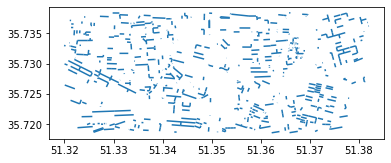

In [20]:
dropped_map = gp.read_file('./ground-map/map/dropped_edges.shp')
dropped_map.plot()
plt.savefig('./dropped.jpg', dpi=150)

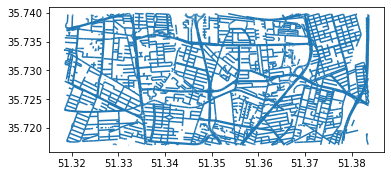

In [21]:
filtered_map = gp.read_file('./ground-map/map/filtered_edges.shp')
filtered_map.plot()
plt.savefig('./filtered.jpg', dpi=150)

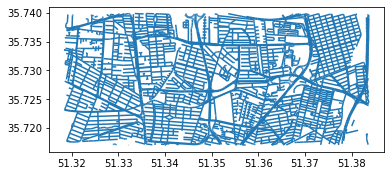

In [22]:
all_map = gp.read_file('./ground-map/map/all_edges.shp')
all_map.plot()
plt.savefig('./all.jpg', dpi=150)

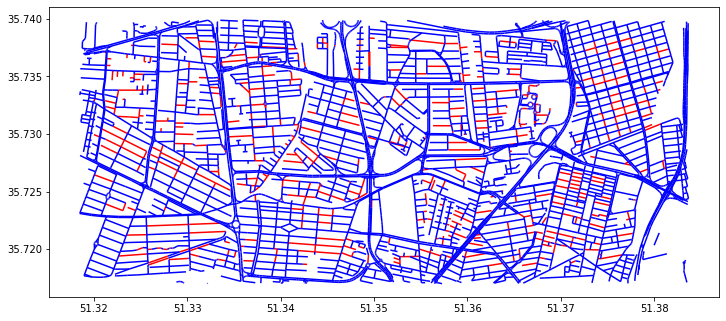

In [24]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize=(12, 8))
cmap = ListedColormap(['yellow'])
dropped_map.plot(color='r', ax=ax, legend=True, label='not enough crossings')
filtered_map.plot(color='b', ax=ax, legend=True, label='dropped edges')
fig.savefig('measure.png', dpi=300)

In [9]:
trajs = pd.read_parquet('./data/gps-data/part-00000-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet')

In [10]:
trajs

,accuracy,altitude,bearing,distance,edge_id,location,provider,receive_timestamp,route_slug,speed,timestamp,app_session,dest_session,device_id,operator,vehicle_type,state,part
0,4.760,1367.1565,212.07027,845.79913,278517952-0,0101000000BB61DBA2CCB64940AD1397E315DC4140,fused,1614569879492,c6047bbd-9b06-44ce-9822-8a1c6673afa2,1.585173e+00,1614569876747,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01
1,5.748,1237.6062,169.10484,47353.11700,306488572-0,0101000000645B069CA5B4494088D7F50B76DB4140,fused,1614569891793,760a6ddb-363f-4639-9b2b-17cc2eaab52f,1.522500e-15,1614569884845,0990a4b6-26e3-4827-ae99-16f07df22338,QmB7WkIapZAPrKr4ooN1,0a0d87eb-e38f-40ee-be49-47917baadaaf,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01
2,4.000,1237.6682,169.06053,47359.63300,306488572-0,01010000006A183E22A6B44940D1EB4FE273DB4140,fused,1614569891793,760a6ddb-363f-4639-9b2b-17cc2eaab52f,3.734164e+00,1614569888893,0990a4b6-26e3-4827-ae99-16f07df22338,QmB7WkIapZAPrKr4ooN1,0a0d87eb-e38f-40ee-be49-47917baadaaf,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01
3,4.637,1367.2018,217.07983,852.84906,278517952-0,01010000008C118942CBB64940BAF59A1E14DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,2.689027e+00,1614569878750,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01
4,4.830,1367.2052,217.07983,859.74790,153170382-0,01010000001CD2A8C0C9B64940D942908312DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,4.119282e+00,1614569880751,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22499,13.333,1252.3323,325.86868,4024.62000,200684336-0,010100000043FE99417CB649403F8C101E6DDC4140,fused,1614571666461,3efbfc7b-502c-408a-aae9-05c3bcd6a4a8,1.767423e+00,1614571658661,co8CaAuJAO6lgfg85Sw9,z9frqjnaDGE4wbnkC3oU,7585bed9-5591-462f-a1ee-6a5879ec4408,Irancell,None,"passed_in_time_window_check,generated_time",2021-03-01
22500,13.600,1252.2386,325.86868,4042.72850,200684336-0,0101000000AB5FE97C78B649404F5B238271DC4140,fused,1614571666461,3efbfc7b-502c-408a-aae9-05c3bcd6a4a8,6.394519e+00,1614571663704,co8CaAuJAO6lgfg85Sw9,z9frqjnaDGE4wbnkC3oU,7585bed9-5591-462f-a1ee-6a5879ec4408,Irancell,None,"passed_in_time_window_check,generated_time",2021-03-01
22501,18.666,1313.0600,117.92153,744.30610,279958152-1,01010000003F6EBF7CB2B64940C156091687DB4140,fused,1614571668562,48ef7564-bf66-4fea-972a-0180a8455b1d,4.267106e+00,1614571658316,QL5yGXZu5hmivIvDLgIH,cr0DEEdWGibqMM5oRWZ7,464decaf-4e20-4efb-870a-543775813ee2,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01
22502,20.400,1313.0600,129.19632,785.03410,279958152-1,0101000000EC3026FDBDB6494030116F9D7FDB4140,fused,1614571668562,48ef7564-bf66-4fea-972a-0180a8455b1d,6.823453e+00,1614571666381,QL5yGXZu5hmivIvDLgIH,cr0DEEdWGibqMM5oRWZ7,464decaf-4e20-4efb-870a-543775813ee2,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01


In [5]:
trajs.timestamp = trajs.timestamp.apply(
    lambda x: datetime.datetime.fromtimestamp(int(x) / 1000)
)

In [7]:
trajs_new = trajs.sort_values(by=['timestamp'])

In [9]:
trajs_before = trajs.sort_values(by=['timestamp'])

In [10]:
trajs_new

,accuracy,altitude,bearing,location,route_slug,speed,timestamp,dest_session,device_id,way_id,dir
181689,29.816,1070.0,179.69992,0101000000A795422097A049406C425A63D0C74140,Al44ohkhmA,19.444596,2020-06-16 08:30:15.843,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181688,16.580,1069.0,179.69992,0101000000A795422097A049406C425A63D0C74140,Al44ohkhmA,20.525234,2020-06-16 08:30:17.329,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181687,16.580,1069.0,179.69992,0101000000A795422097A049406C425A63D0C74140,Al44ohkhmA,20.525234,2020-06-16 08:30:17.843,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181685,3.920,1068.0,180.00000,0101000000E884D04197A04940001E51A1BAC74140,Al44ohkhmA,42.135995,2020-06-16 08:30:25.498,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181686,3.920,1068.0,180.00000,0101000000E884D04197A04940060FD3BEB9C74140,Al44ohkhmA,42.135995,2020-06-16 08:30:26.020,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
...,...,...,...,...,...,...,...,...,...,...,...
453222,42.900,2045.1,155.12950,01010000005305A3923A654940B7B6F0BC541C4040,1QQKoWmu0L,18.557944,2020-09-29 08:59:06.712,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0
453224,78.420,2044.7,139.62280,0101000000335019FF3E6549400133DFC14F1C4040,1QQKoWmu0L,17.490262,2020-09-29 08:59:10.829,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0
453221,81.350,2044.5,139.62280,01010000001AC05B2041654940EA3E00A94D1C4040,1QQKoWmu0L,16.165480,2020-09-29 08:59:12.853,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0
453225,96.000,2044.3,139.33023,0101000000EF9062804465494045F295404A1C4040,1QQKoWmu0L,19.817333,2020-09-29 08:59:15.958,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0


In [15]:
trajs_before

,accuracy,altitude,bearing,location,route_slug,speed,timestamp,dest_session,device_id,way_id,dir
181689,29.816,1070.0,179.69992,0101000000A795422097A049406C425A63D0C74140,Al44ohkhmA,19.444596,1592280015843,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181688,16.580,1069.0,179.69992,0101000000A795422097A049406C425A63D0C74140,Al44ohkhmA,20.525234,1592280017329,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181687,16.580,1069.0,179.69992,0101000000A795422097A049406C425A63D0C74140,Al44ohkhmA,20.525234,1592280017843,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181685,3.920,1068.0,180.00000,0101000000E884D04197A04940001E51A1BAC74140,Al44ohkhmA,42.135995,1592280025498,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
181686,3.920,1068.0,180.00000,0101000000E884D04197A04940060FD3BEB9C74140,Al44ohkhmA,42.135995,1592280026020,UyDvoRq9P1As7Du3mqzH,0ee530a0-6e65-446a-9fa6-78004549102b,287728403,0
...,...,...,...,...,...,...,...,...,...,...,...
453222,42.900,2045.1,155.12950,01010000005305A3923A654940B7B6F0BC541C4040,1QQKoWmu0L,18.557944,1601357346712,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0
453224,78.420,2044.7,139.62280,0101000000335019FF3E6549400133DFC14F1C4040,1QQKoWmu0L,17.490262,1601357350829,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0
453221,81.350,2044.5,139.62280,01010000001AC05B2041654940EA3E00A94D1C4040,1QQKoWmu0L,16.165480,1601357352853,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0
453225,96.000,2044.3,139.33023,0101000000EF9062804465494045F295404A1C4040,1QQKoWmu0L,19.817333,1601357355958,slBopuQ8MwGgsyutDugO,959ddaa6-333f-420a-9737-6ccd65141ba4,359497923,0


In [17]:
len('1301806255')

10

In [16]:
1592280017329-1592280015843

1486

In [23]:
trajs_new.iloc[1].timestamp-trajs_new.iloc[0].timestamp

Timedelta('0 days 00:00:01.486000')

Timestamp('2020-06-16 08:30:17.329000')

In [24]:
1592280017329//1000

1592280017

In [27]:
np.round(1592280017329/1000)

1592280017.0

In [15]:
import pandas as pd
from shapely import wkb
from shapely.geometry import LineString
import geopandas as gp
from tqdm import tqdm
import glob
import hashlib
import sqlite3
import datetime
from itertools import tee
import numpy as np
import os, csv, sys
# from sklearn.metrics.pairwise import haversine_distances
from haversine import haversine, Unit

# METERS_PER_DEGREE_LATITUDE = 111070.34306591158
# METERS_PER_DEGREE_LONGITUDE = 83044.98918812413
EARTH_RADIUS = 6371000 # meters


def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def convert_location(x):
    point = wkb.loads(x, hex=True)
    return point.x, point.y


def thresh_determiner(obj_list, thresh_percent=0.95, n_bins=100):
    bin_values, edges = np.histogram(obj_list, bins=n_bins)
    bin_cum = np.cumsum(bin_values)
    bin_cum = bin_cum / bin_cum[-1]
    threshold = int(edges[np.argmin(abs(bin_cum - thresh_percent)) + 1])
    return threshold


def insert_nodes(node1, node2, n):
    latitudes = np.linspace(node1[0], node2[0], n)
    longitudes = np.linspace(node1[1], node2[1], n)
    nodes = list(zip(longitudes, latitudes))
    return nodes


# def dist_measure(x, y):
#     return np.sqrt(((x[0]-y[0])*METERS_PER_DEGREE_LONGITUDE)**2 + ((x[1]-y[1])*METERS_PER_DEGREE_LATITUDE)**2)
def dist_measure(x, y):
    return haversine(x[:2][::-1], y[:2][::-1], unit=Unit.METERS)


def spd_measure(x, y):
    return dist_measure(x, y)/max((y[3]-x[3]).seconds, 1)


def time_preprocess(trip, time_threshold=20):
    filtered_trip = []
    counter = 0
    for org, dest in pairwise(trip):
        delta = (dest[3]-org[3]).seconds
        filtered_trip.append(org)
        counter += 1
        if delta > time_threshold:
            break
        if counter == len(trip)-1:
            filtered_trip.append(dest)
    return filtered_trip


def dist_preprocess(trip, max_dist_threshold=170, min_dist_threshold=2):
    filtered_trip = []
    while len(trip) > 1:
        org = trip.pop(0)
        delta = dist_measure(org, trip[0])
        if delta < min_dist_threshold:
            _ = trip.pop(0)
            trip.insert(0, org)
            continue
        filtered_trip.append(org)
        if delta > max_dist_threshold:
            break
        if len(trip) == 1:
            filtered_trip.append(trip.pop())
    return filtered_trip


def spd_preprocess(trip, max_spd_threshold=26, min_spd_threshold=2):
    #note: this function just filter data based on avergae speed between two points, not based on the point gps point speed
    filtered_trip = []
    counter = 0
    for org, dest in pairwise(trip):
        delta = spd_measure(org, dest)
        filtered_trip.append(org)
        counter += 1
        if delta > max_spd_threshold or delta < min_spd_threshold:
            break
        if counter == len(trip)-1:
            filtered_trip.append(dest)
    return filtered_trip


def preprocess(trip, **kwargs):
    temp_trip = time_preprocess(
        trip,
        kwargs['time_threshold'] if 'time_threshold' in kwargs else 20
    )
    temp_trip = dist_preprocess(
        temp_trip,
        kwargs['max_dist_threshold'] if 'max_dist_threshold' in kwargs else 170,
        kwargs['min_dist_threshold'] if 'min_dist_threshold' in kwargs else 5
    )
    temp_trip = spd_preprocess(
        temp_trip,
        kwargs['max_spd_threshold'] if 'max_spd_threshold' in kwargs else 26,
        kwargs['min_spd_threshold'] if 'min_spd_threshold' in kwargs else 2
    )
    return temp_trip


def modify_data(file_path, boundary, global_index, **kwargs):
    print(file_path)
    data = pd.read_parquet(file_path)
    # data.sort_values(['route_slug'], inplace=True)
    # data.reset_index(drop=True, inplace=True)

    data.timestamp = data.timestamp.apply(
        lambda x: datetime.datetime.fromtimestamp(int(x) / 1000)
    )
    data.location = data.location.apply(
        lambda x: convert_location(x)
    )
    data['in_bound'] = data.location.apply(
        lambda x: boundary['west'] < x[0] < boundary['east'] and boundary['south'] < x[1] < boundary['north']
    )
    trajectories = []
    temp_trip = []
    # last_index = len(route_mapping)

    # for i in range(len(data['device_id'])):
    for i in range(len(data)-1):
        if data.iloc[i]['in_bound']:
            temp_trip.append([
                data.iloc[i]['location'][0],
                data.iloc[i]['location'][1],
                data.iloc[i]['altitude'],
                data.iloc[i]['timestamp'],
                data.iloc[i]['bearing'],
                data.iloc[i]['speed']
            ])
        else:
            if len(temp_trip) > 1:
                temp_trip = sorted(temp_trip, key=lambda x: x[3])
                temp_trip = preprocess(temp_trip, **kwargs)
                if len(temp_trip) > 1:
                    # route_id = global_index
                    # if data.iloc[i]['route_slug'] in route_mapping.keys():
                    #     route_id = route_mapping[data.iloc[i]['route_slug']]
                    # else:
                    #     route_mapping[data.iloc[i]['route_slug']] = last_index
                    #     route_id = last_index
                    #     last_index += 1
                    trajectories.append(
                        (
                            # np.int64(int(hashlib.md5(data.iloc[i]['route_slug'].encode('utf-8')).hexdigest(), 16) % (10**9)),
                            global_index,
                            temp_trip
                        )
                    )
                    global_index += 1
            temp_trip = []
            continue

        if data.iloc[i]['route_slug'] != data.iloc[i+1]['route_slug']:
            if len(temp_trip) > 1:
                temp_trip = sorted(temp_trip, key=lambda x: x[3])
                temp_trip = preprocess(temp_trip, **kwargs)
                if len(temp_trip) > 1:
                    # if data.iloc[i]['route_slug'] in route_mapping.keys():
                    #     route_id = route_mapping[data.iloc[i]['route_slug']]
                    # else:
                    #     route_mapping[data.iloc[i]['route_slug']] = last_index
                    #     route_id = last_index
                    #     last_index += 1
                    trajectories.append(
                        (
                            global_index,
                            temp_trip
                        )
                    )
                    global_index += 1
            temp_trip = []
    if len(trajectories) == 0:
        print('No bounded points')
    return trajectories, global_index


def load_data(file_path, boundary, file_dist):
    if os.path.exists(file_path) is not True:
        print('Path does not exists!')
        return
    prefix = ''.join(str(int(value)) for value in [
        boundary['west'], boundary['east'], boundary['south'], boundary['north']
    ])
    # route_mapping = {}
    global_index = 0
    for dir_name in [x for x in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, x)) and not x.startswith('.')]:
        if not os.path.exists(file_dist + '/' + prefix):
            os.makedirs(file_dist + '/' + prefix)
        files = sorted(os.listdir(os.path.join(file_path, dir_name)))
        for file in files:
            if not file.endswith('.parquet'):
                continue
            # trajectories, route_mapping = modify_data(os.path.join(file_path, dir_name, file), boundary, route_mapping)
            trajectories, global_index = modify_data(os.path.join(file_path, dir_name, file), boundary, global_index)
            if not trajectories:
                continue
            file_name = file_dist + '/' + prefix + '/' + file.split('.snappy')[0]+'.csv'
            with open(file_name, 'w') as csv_file:
                csv_writer = csv.writer(csv_file, delimiter=',', lineterminator='\n')
                csv_writer.writerow(['route_id', 'longitude', 'latitude', 'altitude', 'timestamp', 'bearing', 'speed'])
                for trajectory in trajectories:
                    for point in trajectory[1]:
                        csv_writer.writerow([trajectory[0]]+point)
    return file_dist + '/' + prefix + '/'


def make_trajs(file_path):
    if os.path.exists(file_path) is not True:
        print('Path does not exists!')
        return
    trajectories = []
    # print('here in make_trajs')
    for dir_name in [x for x in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, x)) and not x.startswith('.')]:
        files = sorted(os.listdir(os.path.join(file_path, dir_name)))
        # print(files)
        for file in tqdm(files, total=len(files)):
            # print('size trajs:', sys.getsizeof(trajectories))
            # print(file)
            # print('len trajs:', len(trajectories))
            if not file.endswith('.csv'):
                # print('not found csv')
                continue
            data = pd.read_csv(os.path.join(file_path, dir_name, file), sep=',', header=0, engine='python')
            # print('size data:', sys.getsizeof(data))
            # print('len data:', len(data))
            altitudes = []
            line = []
            bearings = []
            speeds = []
            for i in range(len(data)-1):
                point = data.iloc[i]
                line.append((point['longitude'], point['latitude']))
                altitudes.append(str(point['altitude']))
                bearings.append(str(point['bearing']))
                speeds.append(str(point['speed']))
                # print(len(line), end='\r')
                if point['route_id'] != data.iloc[i+1]['route_id']:
                    # print('size innerdata:', sys.getsizeof(line), sys.getsizeof(altitudes), sys.getsizeof(bearings), sys.getsizeof(speeds))
                    traj_line = LineString(line)
                    trajectories.append((point['route_id'], traj_line, ','.join(altitudes), ','.join(bearings), ','.join(speeds)))
                    # trajectories.append((point['route_id'], traj_line, ','.join(bearings), ','.join(speeds)))
                    line = []
                    bearings = []
                    speeds = []
                    altitudes = []
    return trajectories

def csv2trajs(dir_path):
    all_files = sorted(glob.glob(os.path.join(dir_path, "*.csv")))
    each_file_df = (pd.read_csv(f) for f in all_files)
    all_trajs = pd.concat(each_file_df, ignore_index=True)
    all_trajs['pre_route_id'] = all_trajs.route_id.shift(1)
    all_trajs = all_trajs[1:]
    all_trajs['pre_route_id'] = all_trajs['pre_route_id'].astype(np.int32)
    trajs_list = []
    first, last = 0, 0
    list2str = lambda x: ','.join([str(y) for y in x])
    all_trajs.reset_index(drop=True, inplace=True)
    for index, row in tqdm(all_trajs.iterrows(), total=len(all_trajs)):
        if row['route_id'] != row['pre_route_id']:
            last = index
            idx_df = all_trajs.iloc[first:last]
            traj_list = list(zip(idx_df.longitude.values, idx_df.latitude.values))
            if len(traj_list) > 1:
                trajs_list.append(
                    (row['pre_route_id'], LineString(traj_list), list2str(idx_df.altitude.tolist()),
                     list2str(idx_df.bearing.tolist()), list2str(idx_df.speed.tolist()))
                )
            first = index
    return trajs_list


def trajToShape(source_path, dist_path):
    # trajectories = make_trajs(source_path)
    trajectories = csv2trajs(source_path)
    df = pd.DataFrame(trajectories, columns=['id', 'geometry', 'altitude', 'bearing', 'speed'])
    df = gp.GeoDataFrame(df, geometry='geometry')
    df.to_file(dist_path, driver='ESRI Shapefile')


def load_unmatched(file_path, unmatches, file_dist):
    if os.path.exists(file_path) is not True:
        print('Path does not exists!')
        return
    unmatch_trajs = pd.DataFrame()
    for dir_name in [x for x in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, x)) and not x.startswith('.')]:
        if not os.path.exists(file_dist + '/unmatched'):
            os.makedirs(file_dist + '/unmatched')
        files = sorted(os.listdir(os.path.join(file_path, dir_name)))
        for file in files:
            if not file.endswith('.csv'):
                continue
            full_path = os.path.join(file_path, dir_name, file)
            print(full_path)
            temp_csv = pd.read_csv(full_path, sep=',', engine='python')
            unmatch_trajs = pd.concat([unmatch_trajs, temp_csv[temp_csv.route_id.isin(unmatches)]])

    file_name = file_dist + '/unmatched/unmatched.csv'
    unmatch_trajs.to_csv(file_name, sep=',', header=True, index=False)
    return file_dist


def edgeToShape(map_dbpath, dist_path, min_length=20, n=5, no_postprocess=True):
    con = sqlite3.connect(map_dbpath)
    edges_df = pd.read_sql_query("SELECT id, in_node, out_node, weight FROM edges", con)
    nodes_df = pd.read_sql_query("SELECT id, latitude, longitude, weight FROM nodes", con)
    nodes_df.set_index('id', drop=True, inplace=True)
    # find the start and end nodes coordinates for each edge of the edges table
    # based on nodes of the nodes table
    # filter edges by minimum length
    if no_postprocess:
        edges_df['way_length'] = edges_df.apply(
            lambda row: haversine(
                (nodes_df.loc[row.in_node].latitude, nodes_df.loc[row.in_node].longitude),
                (nodes_df.loc[row.out_node].latitude, nodes_df.loc[row.out_node].longitude),
                unit=Unit.METERS
            ),
            axis=1)
        edges_df = edges_df[edges_df.way_length > min_length]
        edges_df['in_out'] = edges_df[['in_node', 'out_node']].apply(
            lambda x: tuple(y for y in x), axis=1
        )
        unique_indices = []
        for index, row in edges_df.iterrows():
            if row.in_out[::-1] not in unique_indices:
                unique_indices.append(row.in_out)
        edges_df = edges_df[edges_df.in_out.isin(unique_indices)]
        edges_df.reset_index(drop=True, inplace=True)
    edges = pd.DataFrame({'id': edges_df.index + 1})
    edges['geometry'] = edges_df.apply(
        lambda row: LineString(
            insert_nodes(
                [nodes_df.loc[row.in_node].latitude, nodes_df.loc[row.in_node].longitude],
                [nodes_df.loc[row.out_node].latitude, nodes_df.loc[row.out_node].longitude],
                n
            )
        ),
    axis=1)
    edges = gp.GeoDataFrame(edges, geometry='geometry')
    edges.to_file(dist_path, driver='ESRI Shapefile')


def read_large_size(file_paths, boundary, has_distance=True):
    all_df = []
    for file_path in sorted(file_paths):
        if not file_path.endswith('.parquet'):
            continue
        print(file_path)
        inbound_df = pd.read_parquet(file_path)
        inbound_df.location = inbound_df.location.apply(lambda x: convert_location(x))
        inbound_df['longitude'] = inbound_df.location.apply(lambda x: x[0])
        inbound_df['latitude'] = inbound_df.location.apply(lambda x: x[1])
        inbound_df['in_bound'] = inbound_df.location.apply(
            lambda x: boundary['west'] < x[0] < boundary['east'] and boundary['south'] < x[1] < boundary['north']
        )
        inbound_df = inbound_df[inbound_df.in_bound == True]
        if has_distance:
            inbound_df = inbound_df[
                ['device_id', 'route_slug', 'latitude', 'longitude', 'altitude', 'timestamp', 'bearing', 'speed',
                 'distance']
            ]
        else:
            inbound_df = inbound_df[
                ['device_id', 'route_slug', 'latitude', 'longitude', 'altitude', 'timestamp', 'bearing', 'speed']
            ]
        all_df.append(inbound_df)
    all_df = pd.concat(all_df, ignore_index=True)
    return all_df


def read_small_size(dir_path, boundary, has_distance=True):
    all_df = pd.read_parquet(dir_path)
    all_df.location = all_df.location.apply(lambda x: convert_location(x))
    all_df['longitude'] = all_df.location.apply(lambda x: x[0])
    all_df['latitude'] = all_df.location.apply(lambda x: x[1])
    all_df['in_bound'] = all_df.location.apply(
        lambda x: boundary['west'] < x[0] < boundary['east'] and boundary['south'] < x[1] < boundary['north']
    )
    all_df = all_df[all_df.in_bound == True]
    if has_distance:
        all_df = all_df[
            ['device_id', 'route_slug', 'latitude', 'longitude', 'altitude', 'timestamp', 'bearing', 'speed',
             'distance']
        ]
    else:
        all_df = all_df[
            ['device_id', 'route_slug', 'latitude', 'longitude', 'altitude', 'timestamp', 'bearing', 'speed']
        ]
    return all_df


def save2outformat(input_df, out_format, out_dir, sp_thresh=None):
    idxs = input_df.route_id.unique()
    trajs_list = []
    list2str = lambda x: ','.join([str(y) for y in x])
    if out_format == 'csv':
        split_parts = int(len(input_df) / min(sp_thresh, len(input_df)))
        splitted_idxs = np.array_split(idxs, split_parts)
        for arr in splitted_idxs:
            file_name = os.path.join(out_dir, f'{arr[0]}-{arr[-1]}.csv')
            input_df[input_df.route_id.isin(arr)].to_csv(file_name, sep=',', header=True, index=False)
        for idx in idxs:
            idx_df = input_df[input_df.route_id == idx]
            traj_list = list(zip(idx_df.longitude.values, idx_df.latitude.values))
            trajs_list.append(
                (idx, LineString(traj_list), list2str(idx_df.altitude.tolist()),
                 list2str(idx_df.bearing.tolist()), list2str(idx_df.speed.tolist()))
            )
        df = pd.DataFrame(trajs_list, columns=['id', 'geometry', 'altitude', 'bearing', 'speed'])
    elif out_format == 'txt':
        input_df = input_df[['route_id', 'longitude', 'latitude', 'timestamp']]
        for idx in idxs:
            idx_df = input_df[input_df.route_id == idx]
            idx_df.to_csv(f'trip_{idx}.txt', sep=' ', header=False, index=False)
            traj_list = list(zip(idx_df.longitude.values, idx_df.latitude.values))
            trajs_list.append((idx, LineString(traj_list)))
        df = pd.DataFrame(trajs_list, columns=['id', 'geometry'])
    df = gp.GeoDataFrame(df, geometry='geometry')
    return df

def load_directory(
        dir_path, boundary,
        output_dir, shape_path,
        has_distance=True,
        min_dist_threshold=5,
        max_dist_threshold=170,
        max_time_threshold=20,
        max_spd_threshold=26,
        split_threshold=100000,
        large_size=True,
        files_atonce=50,
        output_format='csv'
):
    file_paths = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]
    total_files = len(file_paths)
    read_files = 0
    last_route_id = 0
    while read_files < total_files:
        if large_size:
            print('loading from large size method')
            all_df = read_large_size(file_paths[read_files:min(read_files + files_atonce, total_files)], boundary,
                                     has_distance)
        else:
            print('loading from small size method')
            all_df = read_small_size(dir_path, boundary, has_distance)
        all_df.timestamp = all_df.timestamp.apply(
            lambda x: datetime.datetime.fromtimestamp(int(x) / 1000)
        )

        all_df['pre_route_slug'] = all_df.shift(1).route_slug
        changed_idxs = list(all_df[all_df.pre_route_slug != all_df.route_slug].index)
        changed_idxs.append(all_df.shape[0])
        changed_idxs = np.array(list(pairwise(changed_idxs)))
        repetitions = changed_idxs[:, 1] - changed_idxs[:, 0]
        all_df['unique_route_slug'] = np.hstack([[i] * repetitions[i] for i in range(repetitions.shape[0])])
        all_df.sort_values(by=['unique_route_slug', 'timestamp'], inplace=True)

        # all_df.sort_values(by=['route_slug', 'timestamp'], inplace=True)
        all_df.reset_index(drop=True, inplace=True)
        all_df['ntraj_points'] = 0
        all_df['route_id'] = 0
        all_df['pr_time'] = all_df.timestamp.shift(1)
        all_df = all_df[1:]
        all_df['delta_time'] = all_df[['timestamp', 'pr_time']].apply(
            lambda x: (x.timestamp - x.pr_time).seconds, axis=1
        )
        if has_distance:
            all_df['pr_distance'] = all_df.distance.shift(1)
            all_df = all_df[1:]
            all_df['delta_dist'] = all_df['distance'] - all_df['pr_distance']
        else:
            all_df['pr_latitude'] = all_df.latitude.shift(1)
            all_df['pr_longitude'] = all_df.longitude.shift(1)
            all_df = all_df[1:]
            all_df['delta_dist'] = all_df[
                ['latitude', 'longitude', 'pr_latitude', 'pr_longitude']
            ].apply(
                lambda x: haversine(
                    (x.latitude, x.longitude),
                    (x.pr_latitude, x.pr_longitude),
                    unit=Unit.METERS
                ), axis=1
            )

        all_df['avg_speed'] = all_df[['delta_dist', 'delta_time']].apply(
            lambda x: x.delta_dist / max(x.delta_time, 1), axis=1
        )
        print('Total number of records before preprocessing: ', len(all_df))

        all_df = all_df[all_df.delta_dist > min_dist_threshold]
        first, last = 0, 0
        for i in range(1, len(all_df)):

            previous = all_df.iloc[i - 1]
            current = all_df.iloc[i]

            if any([
                current['route_slug'] != previous['route_slug'],
                current['delta_time'] > max_time_threshold,
                current['avg_speed'] > max_spd_threshold,
                current['delta_dist'] > max_dist_threshold
            ]):
                last = i
                all_df.iloc[first:last]['ntraj_points'] = last - first
                all_df.iloc[first:last]['route_id'] = last_route_id
                last_route_id += 1
                first = i
        all_df = all_df[all_df.ntraj_points > 1]
        print('Total number of records after preprocessing: ', len(all_df))
        all_df = all_df[
            [
                'route_id',
                'longitude',
                'latitude',
                'altitude',
                'timestamp',
                'bearing',
                'speed'
            ]
        ]
        shapedf = save2outformat(
            input_df=all_df,
            out_format=output_format,
            out_dir=output_dir,
            sp_thresh=split_threshold
        )
        shape_path = shape_path.split('/')
        shape_path = '/'.join(shape_path[:-1]) + \
                     f'/files-{read_files}-{min(read_files + files_atonce, total_files)}-' + \
                     shape_path[-1]
        shapedf.to_file(shape_path, driver='ESRI Shapefile')
        read_files += files_atonce
        if not large_size:
            break
    return all_df

In [16]:
with open('./utils/bounding_box.txt', 'r') as bbx_file:
    north, south, east, west = [float(line.strip('\n').split('=')[1]) for line in bbx_file]

boundary = dict(
    east=east,
    west=west,
    north=north,
    south=south
)

a = load_directory(
    './data/gps-data/',
    boundary,
    './data/gps-csv/',
    './data/trajectories/trajs.shp',
    has_distance=True,
    min_dist_threshold=5,
    max_dist_threshold=170,
    max_time_threshold=20,
    max_spd_threshold=26,
    split_threshold=100000,
    large_size=True,
    files_atonce=50,
    output_format='txt'
)

loading from large size method
./data/gps-data/part-00000-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet
./data/gps-data/part-00001-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet
./data/gps-data/part-00002-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet
./data/gps-data/part-00003-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet
./data/gps-data/part-00004-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet
./data/gps-data/part-00005-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet
Total number of records before preprocessing:  122214


<ipython-input-15-2b38331b9b76>:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df.iloc[first:last]['ntraj_points'] = last - first
<ipython-input-15-2b38331b9b76>:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df.iloc[first:last]['route_id'] = last_route_id


Total number of records after preprocessing:  87217


In [15]:
a.set_index([pd.Index(range(a.shape[0])), 'route_id'], inplace=True)

TypeError: set_index() got an unexpected keyword argument 'by'

In [5]:
b = deepcopy(a)

In [7]:
a.set_index([pd.Index(range(a.shape[0])), 'route_id'], inplace=True)

KeyError: "None of ['route_id'] are in the columns"

In [19]:
a.loc[1, 1]

longitude                       51.4276
latitude                        35.7189
altitude                        1367.21
timestamp    2021-03-01 07:08:10.732000
bearing                         224.016
speed                            6.0209
Name: (1, 1), dtype: object

In [16]:
a

,,longitude,latitude,altitude,timestamp,bearing,speed
,route_id,,,,,,
0,1,51.428032,35.719315,1367.2052,2021-03-01 07:08:00.751,217.079830,4.119282
1,1,51.427643,35.718940,1367.2059,2021-03-01 07:08:10.732,224.015750,6.020903
2,1,51.427555,35.718838,1367.1348,2021-03-01 07:08:12.734,211.285610,7.291307
3,1,51.427414,35.718650,1367.1337,2021-03-01 07:08:14.742,211.285610,6.746124
4,1,51.427357,35.718570,1367.1115,2021-03-01 07:08:17.737,207.151760,6.333875
...,...,...,...,...,...,...,...
87212,35178,51.411520,35.713966,1257.4603,2021-03-01 10:53:42.069,223.315600,5.741189
87213,35179,51.409240,35.711940,1248.2994,2021-03-01 10:53:29.568,71.133010,3.503379
87214,35179,51.410350,35.712570,1247.1825,2021-03-01 10:53:47.557,47.115555,7.524409


In [11]:
all_df = pd.read_parquet('./data/gps-data/part-00000-370bdd89-194f-43cf-9184-a8a6564d0cc5-c000.snappy.parquet')

In [25]:
all_df['pre_route_slug'] = all_df.shift(1).route_slug
all_df[:60]

,accuracy,altitude,bearing,distance,edge_id,location,provider,receive_timestamp,route_slug,speed,timestamp,app_session,dest_session,device_id,operator,vehicle_type,state,part,pre_route_slug
0,4.760,1367.1565,212.07027,845.79913,278517952-0,0101000000BB61DBA2CCB64940AD1397E315DC4140,fused,1614569879492,c6047bbd-9b06-44ce-9822-8a1c6673afa2,1.585173e+00,1614569876747,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,NaN
1,5.748,1237.6062,169.10484,47353.11700,306488572-0,0101000000645B069CA5B4494088D7F50B76DB4140,fused,1614569891793,760a6ddb-363f-4639-9b2b-17cc2eaab52f,1.522500e-15,1614569884845,0990a4b6-26e3-4827-ae99-16f07df22338,QmB7WkIapZAPrKr4ooN1,0a0d87eb-e38f-40ee-be49-47917baadaaf,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
2,4.000,1237.6682,169.06053,47359.63300,306488572-0,01010000006A183E22A6B44940D1EB4FE273DB4140,fused,1614569891793,760a6ddb-363f-4639-9b2b-17cc2eaab52f,3.734164e+00,1614569888893,0990a4b6-26e3-4827-ae99-16f07df22338,QmB7WkIapZAPrKr4ooN1,0a0d87eb-e38f-40ee-be49-47917baadaaf,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,760a6ddb-363f-4639-9b2b-17cc2eaab52f
3,4.637,1367.2018,217.07983,852.84906,278517952-0,01010000008C118942CBB64940BAF59A1E14DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,2.689027e+00,1614569878750,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,760a6ddb-363f-4639-9b2b-17cc2eaab52f
4,4.830,1367.2052,217.07983,859.74790,153170382-0,01010000001CD2A8C0C9B64940D942908312DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,4.119282e+00,1614569880751,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
5,3.900,1367.2059,224.01575,914.33540,153170382-0,010100000082AE7D01BDB64940A4E4D53906DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,6.020903e+00,1614569890732,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
6,3.900,1367.1348,211.28561,928.33320,200684146-0,0101000000E21E4B1FBAB649409F8F32E202DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,7.291307e+00,1614569892734,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
7,3.900,1367.1337,211.28561,952.91700,200684146-0,010100000020ED7F80B5B649409CA223B9FCDB4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,6.746124e+00,1614569894742,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
8,3.900,1367.1115,207.15176,963.05334,279956370-0,0101000000BC5B59A2B3B6494080F10C1AFADB4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,6.333875e+00,1614569897737,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
9,6.333,1244.7466,145.87437,223.55566,295987082-0,010100000058E2016553B64940DC2A8881AEDB4140,fused,1614569908504,c498274f-825a-4d5d-aabe-18990585761c,1.325700e+01,1614569887930,d372b5e2-246b-42a8-ab57-cd0e4f1179ae,e77F2KYbmi6qXEsIA870,7ccfbf3a-4983-49eb-b7bc-d2898fd51ff0,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2


In [20]:
changed_idxs = list(all_df[all_df.pre_route_slug != all_df.route_slug].index)
changed_idxs.append(all_df.shape[0])

In [22]:
changed_idxs[-30:]

array([[22433, 22435],
       [22435, 22436],
       [22436, 22438],
       [22438, 22439],
       [22439, 22440],
       [22440, 22442],
       [22442, 22444],
       [22444, 22447],
       [22447, 22450],
       [22450, 22454],
       [22454, 22456],
       [22456, 22457],
       [22457, 22460],
       [22460, 22464],
       [22464, 22472],
       [22472, 22474],
       [22474, 22477],
       [22477, 22478],
       [22478, 22480],
       [22480, 22482],
       [22482, 22484],
       [22484, 22489],
       [22489, 22491],
       [22491, 22493],
       [22493, 22494],
       [22494, 22496],
       [22496, 22498],
       [22498, 22501],
       [22501, 22503],
       [22503, 22504]])

In [21]:
changed_idxs = np.array(list(pairwise(changed_idxs)))

In [23]:
repetitions = changed_idxs[:, 1] - changed_idxs[:, 0]
print(repetitions[-30:])

[2 1 2 1 1 2 2 3 3 4 2 1 3 4 8 2 3 1 2 2 2 5 2 2 1 2 2 3 2 1]


In [26]:
a = np.hstack([[i] * repetitions[i] for i in range(repetitions.shape[0])])

In [28]:
a.shape

(22504,)

In [29]:
all_df

,accuracy,altitude,bearing,distance,edge_id,location,provider,receive_timestamp,route_slug,speed,timestamp,app_session,dest_session,device_id,operator,vehicle_type,state,part,pre_route_slug
0,4.760,1367.1565,212.07027,845.79913,278517952-0,0101000000BB61DBA2CCB64940AD1397E315DC4140,fused,1614569879492,c6047bbd-9b06-44ce-9822-8a1c6673afa2,1.585173e+00,1614569876747,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,NaN
1,5.748,1237.6062,169.10484,47353.11700,306488572-0,0101000000645B069CA5B4494088D7F50B76DB4140,fused,1614569891793,760a6ddb-363f-4639-9b2b-17cc2eaab52f,1.522500e-15,1614569884845,0990a4b6-26e3-4827-ae99-16f07df22338,QmB7WkIapZAPrKr4ooN1,0a0d87eb-e38f-40ee-be49-47917baadaaf,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
2,4.000,1237.6682,169.06053,47359.63300,306488572-0,01010000006A183E22A6B44940D1EB4FE273DB4140,fused,1614569891793,760a6ddb-363f-4639-9b2b-17cc2eaab52f,3.734164e+00,1614569888893,0990a4b6-26e3-4827-ae99-16f07df22338,QmB7WkIapZAPrKr4ooN1,0a0d87eb-e38f-40ee-be49-47917baadaaf,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,760a6ddb-363f-4639-9b2b-17cc2eaab52f
3,4.637,1367.2018,217.07983,852.84906,278517952-0,01010000008C118942CBB64940BAF59A1E14DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,2.689027e+00,1614569878750,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,760a6ddb-363f-4639-9b2b-17cc2eaab52f
4,4.830,1367.2052,217.07983,859.74790,153170382-0,01010000001CD2A8C0C9B64940D942908312DC4140,fused,1614569899654,c6047bbd-9b06-44ce-9822-8a1c6673afa2,4.119282e+00,1614569880751,4405bb7b-2f1f-465b-bdb3-4c29c35e1cc0,linDZ3OvWMPg9JQWmEjJ,4d0eed18-3ac3-4f47-b654-ad89ad26533a,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,c6047bbd-9b06-44ce-9822-8a1c6673afa2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22499,13.333,1252.3323,325.86868,4024.62000,200684336-0,010100000043FE99417CB649403F8C101E6DDC4140,fused,1614571666461,3efbfc7b-502c-408a-aae9-05c3bcd6a4a8,1.767423e+00,1614571658661,co8CaAuJAO6lgfg85Sw9,z9frqjnaDGE4wbnkC3oU,7585bed9-5591-462f-a1ee-6a5879ec4408,Irancell,None,"passed_in_time_window_check,generated_time",2021-03-01,3efbfc7b-502c-408a-aae9-05c3bcd6a4a8
22500,13.600,1252.2386,325.86868,4042.72850,200684336-0,0101000000AB5FE97C78B649404F5B238271DC4140,fused,1614571666461,3efbfc7b-502c-408a-aae9-05c3bcd6a4a8,6.394519e+00,1614571663704,co8CaAuJAO6lgfg85Sw9,z9frqjnaDGE4wbnkC3oU,7585bed9-5591-462f-a1ee-6a5879ec4408,Irancell,None,"passed_in_time_window_check,generated_time",2021-03-01,3efbfc7b-502c-408a-aae9-05c3bcd6a4a8
22501,18.666,1313.0600,117.92153,744.30610,279958152-1,01010000003F6EBF7CB2B64940C156091687DB4140,fused,1614571668562,48ef7564-bf66-4fea-972a-0180a8455b1d,4.267106e+00,1614571658316,QL5yGXZu5hmivIvDLgIH,cr0DEEdWGibqMM5oRWZ7,464decaf-4e20-4efb-870a-543775813ee2,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,3efbfc7b-502c-408a-aae9-05c3bcd6a4a8
22502,20.400,1313.0600,129.19632,785.03410,279958152-1,0101000000EC3026FDBDB6494030116F9D7FDB4140,fused,1614571668562,48ef7564-bf66-4fea-972a-0180a8455b1d,6.823453e+00,1614571666381,QL5yGXZu5hmivIvDLgIH,cr0DEEdWGibqMM5oRWZ7,464decaf-4e20-4efb-870a-543775813ee2,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-03-01,48ef7564-bf66-4fea-972a-0180a8455b1d


In [33]:
a

,device_id,route_slug,latitude,longitude,altitude,timestamp,bearing,speed,distance,pre_route_slug
0,4d0eed18-3ac3-4f47-b654-ad89ad26533a,c6047bbd-9b06-44ce-9822-8a1c6673afa2,35.719418,51.428120,1367.1565,2021-03-01 07:07:56.747,212.070270,1.585173e+00,845.79913,NaN
1,0a0d87eb-e38f-40ee-be49-47917baadaaf,760a6ddb-363f-4639-9b2b-17cc2eaab52f,35.714540,51.411304,1237.6062,2021-03-01 07:08:04.845,169.104840,1.522500e-15,47353.11700,c6047bbd-9b06-44ce-9822-8a1c6673afa2
2,0a0d87eb-e38f-40ee-be49-47917baadaaf,760a6ddb-363f-4639-9b2b-17cc2eaab52f,35.714474,51.411320,1237.6682,2021-03-01 07:08:08.893,169.060530,3.734164e+00,47359.63300,760a6ddb-363f-4639-9b2b-17cc2eaab52f
3,4d0eed18-3ac3-4f47-b654-ad89ad26533a,c6047bbd-9b06-44ce-9822-8a1c6673afa2,35.719364,51.428078,1367.2018,2021-03-01 07:07:58.750,217.079830,2.689027e+00,852.84906,760a6ddb-363f-4639-9b2b-17cc2eaab52f
4,4d0eed18-3ac3-4f47-b654-ad89ad26533a,c6047bbd-9b06-44ce-9822-8a1c6673afa2,35.719315,51.428032,1367.2052,2021-03-01 07:08:00.751,217.079830,4.119282e+00,859.74790,c6047bbd-9b06-44ce-9822-8a1c6673afa2
...,...,...,...,...,...,...,...,...,...,...
122267,c3340249-2246-435e-97f9-fdbf2dad369c,d911f391-40b3-4ec7-80c2-5b85b7936e35,35.716020,51.407770,1251.7580,2021-03-01 10:53:35.888,8.654615,8.447925e+00,2583.74020,d911f391-40b3-4ec7-80c2-5b85b7936e35
122268,c3340249-2246-435e-97f9-fdbf2dad369c,d911f391-40b3-4ec7-80c2-5b85b7936e35,35.716084,51.407784,1251.7755,2021-03-01 10:53:37.894,8.725608,8.267095e+00,2591.30420,d911f391-40b3-4ec7-80c2-5b85b7936e35
122269,c3340249-2246-435e-97f9-fdbf2dad369c,d911f391-40b3-4ec7-80c2-5b85b7936e35,35.716236,51.407810,1251.8021,2021-03-01 10:53:40.875,8.725608,7.265116e+00,2608.43630,d911f391-40b3-4ec7-80c2-5b85b7936e35
122270,c3340249-2246-435e-97f9-fdbf2dad369c,d911f391-40b3-4ec7-80c2-5b85b7936e35,35.716260,51.407795,1251.8250,2021-03-01 10:53:43.920,297.980320,3.037705e+00,2611.99240,d911f391-40b3-4ec7-80c2-5b85b7936e35


In [44]:
len(set(range(122272))-set(a.index))

56

In [43]:
a.loc[1537]

KeyError: 1537

In [39]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [2]:
df1 = pd.read_parquet('./part-00000-7987283e-4554-43e1-b547-448f004cf903-c000.snappy.parquet')
df2 = pd.read_parquet('./part-01284-7987283e-4554-43e1-b547-448f004cf903-c000.snappy.parquet')

In [4]:
df1['timestamp'] = df1.timestamp.apply(
    lambda x: datetime.datetime.fromtimestamp(int(x) / 1000)
)
df2['timestamp'] = df2.timestamp.apply(
    lambda x: datetime.datetime.fromtimestamp(int(x) / 1000)
)

In [5]:
df1

,accuracy,altitude,bearing,distance,edge_id,location,provider,receive_timestamp,route_slug,speed,timestamp,app_session,dest_session,device_id,operator,vehicle_type,state,part
0,6.400,1360.9500,89.965706,10935.81400,343042133-1,0101000000000000C062B74940000000C0E4DF4140,fused,1623613136105,ecffc978-4364-418c-abfc-0bb60eeeb363,22.698975,2021-06-14 00:08:43.759,ab7896c6-3f1b-4372-8725-538d4c2372c8,CtVOVEGYEGf8HRPD2GZS,6677877c-713b-4995-9e96-30fbed9ac505,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-06-14
1,7.700,1347.5214,187.645390,1939.45150,360881177-0,01010000000000002070B14940000000009BE04140,fused,1623613156588,d15ed46f-e7f9-4fbf-be72-940e9aafef9d,4.856125,2021-06-14 00:09:05.723,bfd33359-ef72-4cf7-9abf-ec0c58580f07,z1vSZdRD8MYN3b7ZLCbm,8282cd90-27d3-4559-97d9-1b120418862a,Irancell,None,"passed_in_time_window_check,generated_time",2021-06-14
2,7.000,1365.3090,80.550380,11150.68300,343042133-1,010100000000000080B0B74940000000E0E6DF4140,fused,1623613157830,ecffc978-4364-418c-abfc-0bb60eeeb363,21.254145,2021-06-14 00:08:53.247,ab7896c6-3f1b-4372-8725-538d4c2372c8,CtVOVEGYEGf8HRPD2GZS,6677877c-713b-4995-9e96-30fbed9ac505,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-06-14
3,7.000,1364.6622,80.550380,11192.80300,193095610-0,0101000000000000A0BFB74940000000E0E8DF4140,fused,1623613157828,ecffc978-4364-418c-abfc-0bb60eeeb363,20.915956,2021-06-14 00:08:55.265,ab7896c6-3f1b-4372-8725-538d4c2372c8,CtVOVEGYEGf8HRPD2GZS,6677877c-713b-4995-9e96-30fbed9ac505,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-06-14
4,6.000,1362.5340,89.946410,10686.44400,343042134-1,01010000000000006008B7494000000000E5DF4140,fused,1623613137421,ecffc978-4364-418c-abfc-0bb60eeeb363,22.982424,2021-06-14 00:08:32.753,ab7896c6-3f1b-4372-8725-538d4c2372c8,CtVOVEGYEGf8HRPD2GZS,6677877c-713b-4995-9e96-30fbed9ac505,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-06-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202669,3.900,1410.6390,279.096400,632.48260,360995415-0,0101000000000000802BB749400000000013E24140,fused,1623616376848,94f1ed31-d53d-4030-86ae-532a83a03452,10.468265,2021-06-14 01:02:41.673,f54b77f5-3823-4e76-964b-d91db0846e51,X6FOLp6mB432YlPIITxX,1d1d934f-792e-40db-a41b-98402b80d181,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-06-14
202670,3.881,1504.6481,337.565640,440.79788,279886576-0,010100000000000080BAAE4940000000A07DE24140,fused,1623616376961,af304e63-d92c-44b9-b300-f08f47c1df2b,10.311990,2021-06-14 01:02:39.155,a5408cb1-0135-420e-bc02-f7270be2ccd1,8dNUPSpgRsiAS8Ivmxtg,844b7645-9b59-424e-857d-54c873a6cdab,Irancell,None,"passed_in_time_window_check,generated_time",2021-06-14
202671,3.900,1410.8469,279.096400,506.48020,360995415-0,01010000000000008058B74940000000000DE24140,fused,1623616376988,94f1ed31-d53d-4030-86ae-532a83a03452,2.522598,2021-06-14 01:02:27.686,f54b77f5-3823-4e76-964b-d91db0846e51,X6FOLp6mB432YlPIITxX,1d1d934f-792e-40db-a41b-98402b80d181,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-06-14
202672,3.900,1409.7708,279.096400,564.01290,360995415-0,01010000000000000044B74940000000C00FE24140,fused,1623616376994,94f1ed31-d53d-4030-86ae-532a83a03452,8.932055,2021-06-14 01:02:35.174,f54b77f5-3823-4e76-964b-d91db0846e51,X6FOLp6mB432YlPIITxX,1d1d934f-792e-40db-a41b-98402b80d181,IR-MCI,None,"passed_in_time_window_check,generated_time",2021-06-14


In [2]:
import geopandas as gp

In [3]:
df = gp.read_file('./test areas/janat-abad-trajectories/trajectories/trajs.shp')

In [4]:
df

,id,altitude,bearing,speed,geometry
0,0,"1427.7,1437.7","31.147167,47.054375","34.315542,44.9749044","LINESTRING (51.33224 35.74940, 51.33314 35.75011)"
1,1,"1418.2714,1417.5846","278.7724,278.7724","71.26378559999999,73.3847868","LINESTRING (51.32763 35.75162, 51.32745 35.75164)"
2,2,"1463.4,1461.3,1456.0,1451.0,1444.5","276.1426,279.17444,278.7724,278.7724,279.44437","65.09779920000001,66.875724,66.59791919999999,...","LINESTRING (51.33014 35.75131, 51.32916 35.751..."
3,3,"1428.8868,1425.914,1421.0485,1419.3473,1419.3473","276.1426,279.17444,278.7724,279.44437,279.44437","63.88498800000001,64.8675,71.19964080000003,71...","LINESTRING (51.32987 35.75133, 51.32866 35.751..."
4,4,"1435.8,1431.4,1431.4,1431.0,1428.6","278.7724,279.81003,279.81003,279.44437,281.13855","65.08266479999999,64.5413616,64.5413616,62.748...","LINESTRING (51.32794 35.75158, 51.32653 35.751..."
...,...,...,...,...,...
285604,24107,"1383.0,1383.0,1384.0,1384.0","355.67957,355.67957,354.6052,354.6052","39.9349764,39.9349764,42.1830162,42.1830162","LINESTRING (51.33241 35.74538, 51.33241 35.745..."
285605,24108,"1395.2,1395.2","354.6052,354.6052","26.16336864,35.953005600000004","LINESTRING (51.33240 35.74549, 51.33239 35.74559)"
285606,24109,"1389.7999,1389.7999,1389.7999","355.67957,354.6052,354.6052","27.4826736,33.52449240000001,27.46673172","LINESTRING (51.33242 35.74531, 51.33240 35.745..."
285607,24110,"1376.5868,1377.9744,1377.9744","354.6052,354.6052,354.6052","43.89313320000001,45.6294096,45.6294096","LINESTRING (51.33240 35.74546, 51.33239 35.745..."
